# Spectral Resistance Embedding on the Zachary Karate Club Network

This notebook illustrates **spectral embeddings** based on the graph Laplacian eigen-decomposition.

We use the **(unweighted) Laplacian** \(L = D - A\) and its nonzero eigenpairs $(\lambda_k,\mathbf{u}_k)$, $k=2,\dots,n$.

A standard *electrical/resistance-distance* embedding of dimension $d$ is
$$
\mathbf{x}_i
=
\left[\frac{u_2(i)}{\sqrt{\lambda_2}},\;
      \frac{u_3(i)}{\sqrt{\lambda_3}},\;\dots,\;
      \frac{u_{d+1}(i)}{\sqrt{\lambda_{d+1}}}
\right]\in\mathbb{R}^{d}.
$$
With the full $d=n-1$ embedding, the squared Euclidean distance recovers the **effective resistance**:
$$
\|\mathbf{x}_i-\mathbf{x}_j\|_2^2
=
(\mathbf{e}_i-\mathbf{e}_j)^\top L^\dagger(\mathbf{e}_i-\mathbf{e}_j)
=
R_{i,j}.
$$

## Imports and Computational Setup

In this section we import the numerical and graph-processing libraries required for the spectral embedding analysis.

- **NumPy** is used for linear algebra operations and eigen-decomposition of the Laplacian matrix.
- **NetworkX** provides access to the Zachary Karate Club network and graph utilities.
- **Matplotlib** is used for 2D and 3D visualization of the spectral embeddings.
- The `Axes3D` toolkit enables 3D plotting functionality.
- We also configure NumPy’s printing format for cleaner numerical output.

In [30]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# For 3D plotting
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

np.set_printoptions(precision=4, suppress=True)

## Loading the Zachary Karate Club Network and Constructing the Laplacian

We load the classical **Zachary Karate Club network**, a benchmark social network with
$ n = 34 $ nodes representing members of a karate club and edges representing social interactions.

We then:

1. Extract the number of nodes $n$ and edges $m$, and verify that the graph is connected.
2. Construct the sparse **adjacency matrix** $A \in \mathbb{R}^{n \times n}$.
3. Compute the **degree vector** $d_i = \sum_j A_{ij}$.
4. Form the (unweighted) sparse **graph Laplacian**
   $$
   L = D - A,
   $$
   where $D = \mathrm{diag}(d)$ is the diagonal matrix of degrees.

Finally, we perform a basic spectral sanity check by computing the smallest eigenvalues of \(L\).
For a connected graph, the Laplacian must be:

- Symmetric,
- Have exactly one zero eigenvalue,
- The rest of eigenvalues are positive.

Nodes: 34, Edges: 78
Is connected? True
Smallest eigenvalues of L: [-0.      1.1871  2.3943  2.9318  2.9683]


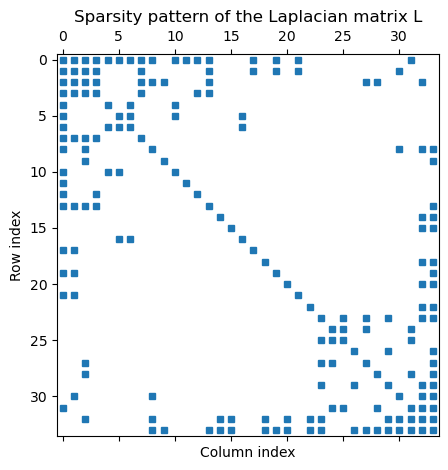

Number of nonzero entries in L: 190
Matrix density: 0.1644


In [31]:
# Load the Zachary Karate Club network
G = nx.karate_club_graph()
n = G.number_of_nodes()
m = G.number_of_edges()

print(f"Nodes: {n}, Edges: {m}")
print("Is connected?", nx.is_connected(G))

# Adjacency and Laplacian (unweighted)
A = nx.to_numpy_array(G, dtype=float)  # shape (n,n)
deg = A.sum(axis=1)
L = np.diag(deg) - A

# Sanity check: L should be symmetric PSD
eigvals_L = np.linalg.eigvalsh(L)
print("Smallest eigenvalues of L:", eigvals_L[:5])

# ---------------------------------------------------
# Sparsity structure of the Laplacian
# ---------------------------------------------------

plt.figure()
plt.spy(L, markersize=5)
plt.title("Sparsity pattern of the Laplacian matrix L")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.tight_layout()
plt.show()

# Density information
num_nonzeros = np.count_nonzero(L)
density = num_nonzeros / (n * n)

print(f"Number of nonzero entries in L: {num_nonzeros}")
print(f"Matrix density: {density:.4f}")

## Spectral Decomposition of the Graph Laplacian

We now compute the eigen-decomposition of the (symmetric) Laplacian matrix
$$
L = U \Lambda U^\top,
$
where $ \Lambda = \mathrm{diag}(\lambda_1, \dots, \lambda_n) $
contains the eigenvalues and the columns of $U$ are the corresponding orthonormal eigenvectors.

For a connected graph:

- The smallest eigenvalue satisfies $ \lambda_1 = 0 $.
- The associated eigenvector is proportional to the constant vector $ \mathbf{1}_n $.
- All remaining eigenvalues are strictly positive:
  $
  0 = \lambda_1 < \lambda_2 \le \dots \le \lambda_n.
  $

Since resistance-based embeddings rely only on the **nonzero eigenvalues**,
we remove the trivial zero eigenvalue and retain the $n-1$ positive eigenpairs.

Number of positive eigenvalues: 33
First 5 positive eigenvalues: [1.1871 2.3943 2.9318 2.9683 3.061 ]

Smallest eigenvalue lambda_1: 9.354220317343246e-15
Correlation between u1 and 1_n: -1.0


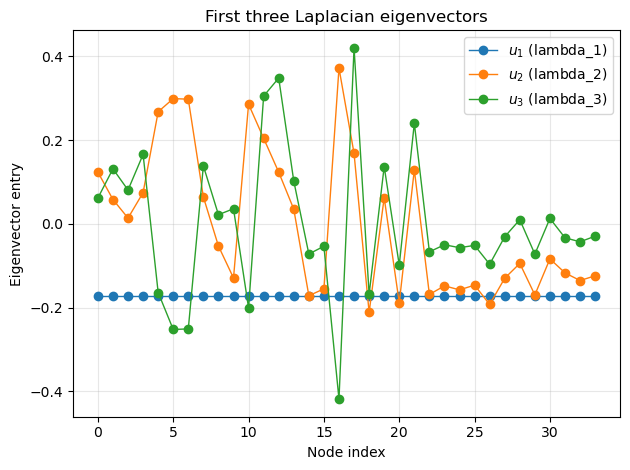

In [32]:
# Eigen-decomposition of the Laplacian
# For a connected graph: lambda_1 = 0, eigenvector ~ 1_n
eigvals, eigvecs = np.linalg.eigh(L)  # sorted ascending for symmetric matrices

# Separate the zero eigenvalue and keep the positive ones
tol = 1e-10
pos_idx = np.where(eigvals > tol)[0]  # indices 1..n-1 for connected graphs
lam = eigvals[pos_idx]                # (n-1,)
U = eigvecs[:, pos_idx]               # (n, n-1)

print("Number of positive eigenvalues:", len(lam))
print("First 5 positive eigenvalues:", lam[:5])

# ---------------------------------------------------
# Verify that the smallest-eigenvalue eigenvector is proportional to 1_n
# and display the 2nd and 3rd eigenvectors
# ---------------------------------------------------

u1 = eigvecs[:, 0]              # eigenvector associated with lambda_1
one = np.ones(n)

# u1 should be proportional to 1_n, up to a sign:
# estimate the proportionality constant via least squares:
alpha = (one @ u1) / (one @ one)
residual = np.linalg.norm(u1 - alpha * one)
relative_residual = residual / np.linalg.norm(u1)

print("\nSmallest eigenvalue lambda_1:", eigvals[0])

# Also check correlation magnitude (should be ~1)
corr = (one @ u1) / (np.linalg.norm(one) * np.linalg.norm(u1))
print("Correlation between u1 and 1_n:", corr)

# Show the first few entries of u1, u2, u3
u2 = eigvecs[:, 1]              # eigenvector associated with lambda_2
u3 = eigvecs[:, 2]              # eigenvector associated with lambda_3

# Plot u1, u2, u3 as functions of node index
plt.figure()
plt.plot(u1, marker='o', linewidth=1, label=r"$u_1$ (lambda_1)")
plt.plot(u2, marker='o', linewidth=1, label=r"$u_2$ (lambda_2)")
plt.plot(u3, marker='o', linewidth=1, label=r"$u_3$ (lambda_3)")
plt.title("First three Laplacian eigenvectors")
plt.xlabel("Node index")
plt.ylabel("Eigenvector entry")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Resistance-Distance Spectral Embedding

We now construct the **resistance-distance spectral embedding** of the graph.

Let the nonzero Laplacian eigenpairs be
$$
(\lambda_k, \mathbf{u}_k), \quad k=2,\dots,n,
$$
with $ \lambda_k > 0 $ and orthonormal eigenvectors $ \mathbf{u}_k $.

The $d$-dimensional embedding of node $i$ is defined as
$$
\mathbf{x}_i
=
\left[
\frac{u_2(i)}{\sqrt{\lambda_2}},
\frac{u_3(i)}{\sqrt{\lambda_3}},
\dots,
\frac{u_{d+1}(i)}{\sqrt{\lambda_{d+1}}}
\right] \in \mathbb{R}^d.
$$

With the full embedding dimension $d = n-1$, the squared Euclidean distance satisfies
$$
\|\mathbf{x}_i - \mathbf{x}_j\|_2^2
=
(\mathbf{e}_i - \mathbf{e}_j)^\top L^\dagger (\mathbf{e}_i - \mathbf{e}_j),
$$
which equals the **effective resistance** between nodes $i$ and $j$.

We first compute the full $(n-1)$-dimensional embedding, and then inspect a few node vectors.

In [33]:
def spectral_embedding(U, lam, d=None):
    '''
    Resistance-distance spectral embedding:
        X_d[i,k] = U[i,k] / sqrt(lam[k])   for k=0..d-1
    where U contains eigenvectors associated with positive eigenvalues lam.
    '''
    if d is None:
        d = U.shape[1]
    d = int(d)
    U_d = U[:, :d]
    lam_d = lam[:d]
    X = U_d / np.sqrt(lam_d)[None, :]   # broadcast scale columns by 1/sqrt(lambda_k)
    return X

# Full embedding of dimension n-1
X_full = spectral_embedding(U, lam, d=n-1)
print("X_full shape:", X_full.shape)

# Show embedding vectors for a few nodes
sample_nodes = [0, 1, 2, 33]  # arbitrary examples (0-based indexing)
d_show = 8  # show first few coordinates for readability
for i in sample_nodes:
    print(f"Node {i}: first {d_show} coordinates of full embedding:")
    print(X_full[i, :d_show])
    print()

X_full shape: (34, 33)
Node 0: first 8 coordinates of full embedding:
[ 0.1132  0.0398 -0.0082 -0.0037 -0.0008 -0.0052 -0.0146 -0.0009]

Node 1: first 8 coordinates of full embedding:
[ 0.0532  0.0848  0.0198  0.0175 -0.0063 -0.0297 -0.0453 -0.0078]

Node 2: first 8 coordinates of full embedding:
[ 0.0126  0.0521  0.0241 -0.0042 -0.0083 -0.0238 -0.0154  0.0052]

Node 33: first 8 coordinates of full embedding:
[-0.1138 -0.019   0.0014 -0.0028 -0.0029  0.0061  0.0001  0.0033]



## 1D Spectral Embedding (Fiedler Coordinate)

We now consider the **one-dimensional resistance-distance embedding**, obtained from the first nonzero Laplacian eigenpair.

For a connected graph,
$$
0 = \lambda_1 < \lambda_2 \le \dots \le \lambda_n,
$$
and the eigenvector associated with $ \lambda_2 $ is known as the **Fiedler vector**.

The 1D embedding of node $i$ is
$$
x_i(1) = \frac{u_2(i)}{\sqrt{\lambda_2}}.
$$
This coordinate reveals the natural bipartition of the network into two communities.

In the plot below:
- Each node is placed on the real line using its 1D spectral coordinate.
- Nodes are colored according to their Karate Club faction (ground truth).
- The labels correspond to node indices.

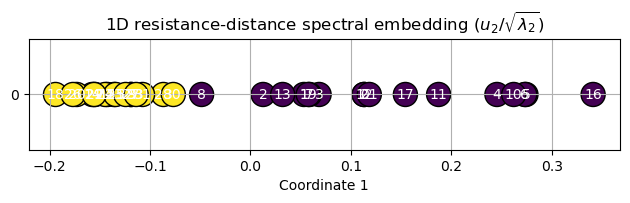

In [34]:
# 1D embedding (use the first nonzero eigenpair)
X1 = spectral_embedding(U, lam, d=1).flatten()

# Extract club membership (two groups)
clubs = nx.get_node_attributes(G, "club")
group_labels = np.array([0 if clubs[i] == "Mr. Hi" else 1 for i in range(n)])

plt.figure()

# Plot points on a line (y=0) with larger markers and coloring by group
plt.scatter(
    X1,
    np.zeros_like(X1),
    c=group_labels,
    s=300,
    edgecolors='k',
    linewidths=1
)

# Add node labels (larger font)
for i in range(n):
    plt.text(
        X1[i],
        0.0,
        str(i),
        fontsize=10,
        ha='center',
        va='center',
        color='white'
    )

plt.title(r"1D resistance-distance spectral embedding ($u_2 / \sqrt{\lambda_2}$)")
plt.xlabel("Coordinate 1")
plt.yticks([0])
plt.grid(True)

# Keep equal tick spacing visually meaningful by enforcing equal scaling
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

## 2D Resistance-Distance Spectral Embedding

We now construct the two-dimensional resistance-distance embedding using the first two nonzero Laplacian eigenpairs.

The embedding coordinates of node $ i $ are
$$
\mathbf{x}_i(2)
=
\left[
\frac{u_2(i)}{\sqrt{\lambda_2}},
\frac{u_3(i)}{\sqrt{\lambda_3}}
\right].
$$

Geometrically:
- The first coordinate corresponds to the **Fiedler direction**, which captures the dominant nontrivial variation in the graph.
- The second coordinate refines this structure by incorporating the next spectral mode.
- Distances in this embedding approximate effective resistance distances.

In the visualization:
- Each node is plotted in $\mathbb{R}^2$ using its spectral coordinates.
- Nodes are colored according to their Karate Club faction.
- Equal axis scaling ensures that Euclidean distances are not visually distorted.

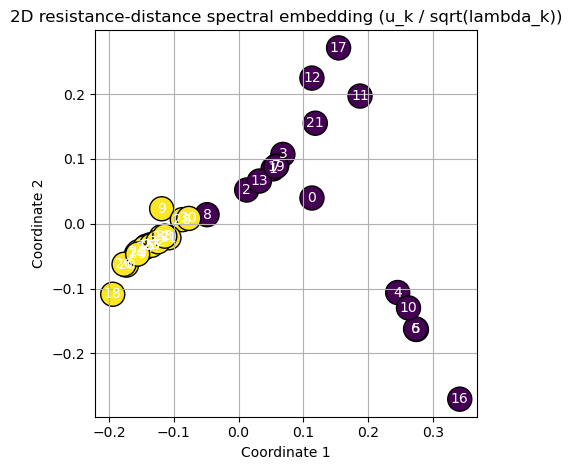

In [35]:
# 2D embedding (use the first two nonzero eigenpairs)
X2 = spectral_embedding(U, lam, d=2)

# Extract club membership (two groups)
clubs = nx.get_node_attributes(G, "club")
group_labels = np.array([0 if clubs[i] == "Mr. Hi" else 1 for i in range(n)])

plt.figure()

# Scatter with larger nodes and coloring by group
scatter = plt.scatter(
    X2[:, 0],
    X2[:, 1],
    c=group_labels,
    s=300,              # larger node size
    edgecolors='k',     # black border for visibility
    linewidths=1
)

# Add node labels (larger font)
for i in range(n):
    plt.text(
        X2[i, 0],
        X2[i, 1],
        str(i),
        fontsize=10,
        ha='center',
        va='center',
        color='white'
    )

plt.title("2D resistance-distance spectral embedding (u_k / sqrt(lambda_k))")
plt.xlabel("Coordinate 1")
plt.ylabel("Coordinate 2")

# Equal axis scaling
plt.gca().set_aspect('equal', adjustable='box')

# Add grid and ticks
plt.grid(True)
plt.xticks()
plt.yticks()

plt.tight_layout()
plt.show()

Best azimuth (elev=25): 160 degrees
Separation score: 1.5273


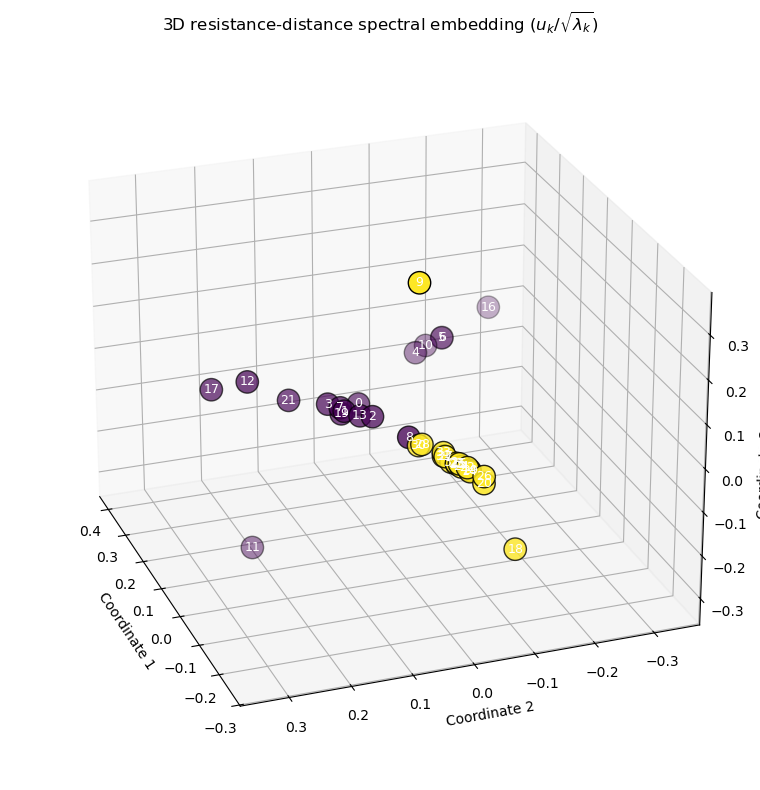

In [36]:
# 3D embedding
X3 = spectral_embedding(U, lam, d=3)

# Extract club membership (two groups)
clubs = nx.get_node_attributes(G, "club")
group_labels = np.array([0 if clubs[i] == "Mr. Hi" else 1 for i in range(n)])

# ---------------------------------------------------
# Data-driven choice of azimuth to maximize separation
# ---------------------------------------------------

def rotate_for_view(X, elev_deg, azim_deg):
    """
    Approximate Matplotlib's 3D view rotation:
    - azim: rotation about z-axis
    - elev: rotation about x-axis
    Then use orthographic projection onto (x,y).
    """
    elev = np.deg2rad(elev_deg)
    azim = np.deg2rad(azim_deg)

    # Rotate around z by azim
    Rz = np.array([
        [np.cos(azim), -np.sin(azim), 0.0],
        [np.sin(azim),  np.cos(azim), 0.0],
        [0.0,           0.0,          1.0]
    ])

    # Rotate around x by elev
    Rx = np.array([
        [1.0, 0.0,           0.0],
        [0.0, np.cos(elev), -np.sin(elev)],
        [0.0, np.sin(elev),  np.cos(elev)]
    ])

    return (Rx @ (Rz @ X.T)).T  # shape (n,3)

def separation_score_2d(Y2, labels, eps=1e-12):
    """Fisher-like separation: centroid distance / pooled within spread."""
    Y0 = Y2[labels == 0]
    Y1 = Y2[labels == 1]

    mu0 = Y0.mean(axis=0)
    mu1 = Y1.mean(axis=0)

    # Within-class cov traces (robust to small sample)
    C0 = np.cov(Y0.T, bias=True)
    C1 = np.cov(Y1.T, bias=True)

    within = np.trace(C0) + np.trace(C1) + eps
    between = np.linalg.norm(mu0 - mu1)
    return between / np.sqrt(within)

# Choose an elevation and scan azimuths
elev = 25
azims = np.arange(0, 360, 1)
scores = []

for az in azims:
    Xr = rotate_for_view(X3, elev_deg=elev, azim_deg=az)
    Y2 = Xr[:, :2]  # orthographic projection
    scores.append(separation_score_2d(Y2, group_labels))

scores = np.array(scores)
best_azim = int(azims[np.argmax(scores)])
print(f"Best azimuth (elev={elev}): {best_azim} degrees")
print(f"Separation score: {scores.max():.4f}")

# ---------------------------------------------------
# Plot with larger figure and chosen viewing angle
# ---------------------------------------------------

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    X3[:, 0], X3[:, 1], X3[:, 2],
    c=group_labels,
    s=260,
    edgecolors='k',
    linewidths=1
)

for i in range(n):
    ax.text(
        X3[i, 0], X3[i, 1], X3[i, 2],
        str(i),
        fontsize=9,
        ha='center',
        va='center',
        color='white'
    )

ax.set_title(r"3D resistance-distance spectral embedding ($u_k / \sqrt{\lambda_k}$)")
ax.set_xlabel("Coordinate 1")
ax.set_ylabel("Coordinate 2")
ax.set_zlabel("Coordinate 3")

# Equal axis scaling (so geometry isn't distorted)
max_range = np.array([
    X3[:, 0].max() - X3[:, 0].min(),
    X3[:, 1].max() - X3[:, 1].min(),
    X3[:, 2].max() - X3[:, 2].min()
]).max() / 2.0
mid_x = (X3[:, 0].max() + X3[:, 0].min()) * 0.5
mid_y = (X3[:, 1].max() + X3[:, 1].min()) * 0.5
mid_z = (X3[:, 2].max() + X3[:, 2].min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.grid(True)
ax.view_init(elev=elev, azim=best_azim)

plt.tight_layout()
plt.show()

## Approximation error vs. embedding dimension \(d\)

Let $X_{\text{full}}\in\mathbb{R}^{n\times(n-1)}$ be the full resistance-distance embedding and let
$D_{\text{full}}\in\mathbb{R}^{n\times n}$ be the matrix of **all-pairs squared Euclidean distances** induced by $X_{\text{full}}$, i.e.,
$$
(D_{\text{full}})_{ij}
=
\|\mathbf{x}_i(n-1)-\mathbf{x}_j(n-1)\|_2^2.
$$

For each truncation dimension $d\in\{1,2,\dots,n-1\}$, define the truncated embedding
$\mathbf{x}_i(d)\in\mathbb{R}^d$ and the corresponding squared-distance matrix $D_d$.

We quantify the approximation quality using the **relative Frobenius error**
$$
\mathrm{err}(d)
=
\frac{\|D_d - D_{\text{full}}\|_F}{\|D_{\text{full}}\|_F}.
$$

A smaller value of $\mathrm{err}(d)$ indicates that the $d$-dimensional embedding preserves the
(resistance-based) geometry more accurately.

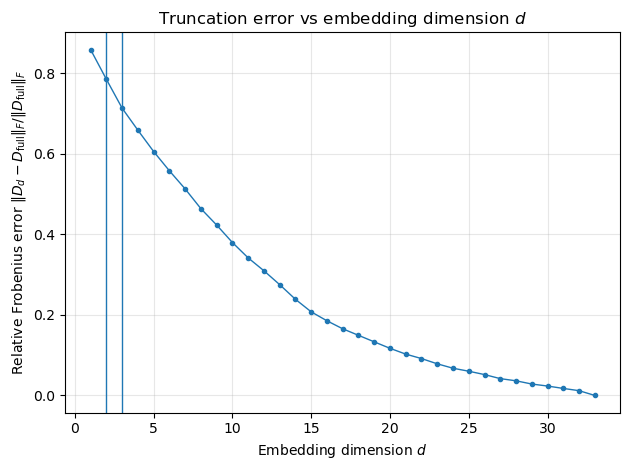

Error at d=1:   0.859229
Error at d=2:   0.785559
Error at d=3:   0.713775
Error at d=n-1: 0.000000e+00


In [37]:
# Compute truncation error curve err(d) = ||D_d - D_full||_F / ||D_full||_F

ds = np.arange(1, n)  # d = 1,2,...,n-1
errs = np.empty_like(ds, dtype=float)

norm_full = np.linalg.norm(D_full, ord='fro')
if norm_full == 0:
    raise ValueError("||D_full||_F is zero (unexpected). Check D_full construction.")

for idx, d in enumerate(ds):
    Xd = spectral_embedding(U, lam, d=d)
    Dd = pairwise_sq_dists(Xd)
    errs[idx] = np.linalg.norm(Dd - D_full, ord='fro') / norm_full

# Plot error vs dimension
plt.figure()
plt.plot(ds, errs, marker='o', markersize=3, linewidth=1)
plt.title("Truncation error vs embedding dimension $d$")
plt.xlabel("Embedding dimension $d$")
plt.ylabel(r"Relative Frobenius error $\|D_d - D_{\mathrm{full}}\|_F / \|D_{\mathrm{full}}\|_F$")
plt.grid(True, alpha=0.3)

# Useful reference markers
plt.axvline(2, linewidth=1)
plt.axvline(3, linewidth=1)

plt.tight_layout()
plt.show()


# Report a few key values (guarding indexing)
def err_at(d):
    return errs[d - 1]  # since ds starts at 1


print(f"Error at d=1:   {err_at(1):.6f}")
print(f"Error at d=2:   {err_at(2):.6f}")
print(f"Error at d=3:   {err_at(3):.6f}")
print(f"Error at d=n-1: {errs[-1]:.6e}")

## Notes

- **Why the scaling $1/\sqrt{\lambda_k}$ matters.**
  The embedding is derived from the spectral decomposition of the Laplacian pseudoinverse
  $$
  L^\dagger = \sum_{k=2}^{n} \frac{1}{\lambda_k}\,\mathbf{u}_k \mathbf{u}_k^\top.
  $$
  Writing
  $$
  \mathbf{x}_i(d)
  =
  \left[
  \frac{u_2(i)}{\sqrt{\lambda_2}},\dots,
  \frac{u_{d+1}(i)}{\sqrt{\lambda_{d+1}}}
  \right]
  $$
  ensures that
  $$
  \|\mathbf{x}_i(n-1)-\mathbf{x}_j(n-1)\|_2^2
  =
  (\mathbf{e}_i-\mathbf{e}_j)^\top L^\dagger (\mathbf{e}_i-\mathbf{e}_j),
  $$
  i.e., squared Euclidean distances coincide with **effective resistance**.
  Without this scaling, the embedding would correspond only to raw eigenvectors and would not represent resistance geometry.

- **Spectral decay and geometric dimension.**
  If the Laplacian spectrum has a pronounced gap after a few small eigenvalues,
  $$
  \lambda_{d+1} \ll \lambda_{d+2},
  $$
  then most of the resistance geometry is captured by the first $d$ modes.
  In this case, the graph behaves as if it were approximately **low-dimensional** in resistance space.

- **Geometric interpretation.**
  The embedding can be viewed as performing classical multidimensional scaling (MDS) on the resistance distance matrix.
  The coordinates are precisely the principal components of $L^\dagger$.